---
title: "seasonal decomposition"
execute:
  # echo: false
  freeze: auto  # re-render only when source changes
format:
  html:
    code-fold: true
    code-summary: "Show the code"
---

In [30]:
#| code-summary: "import stuff"
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()  # datetime converter for a matplotlib
import seaborn as sns
sns.set(style="ticks", font_scale=1.5)
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from datetime import datetime as dt
import time
%matplotlib widget

## trends in atmospheric carbon dioxide

Mauna Loa CO2 concentration.  
data from [NOAA](https://gml.noaa.gov/ccgg/trends/data.html)

In [63]:
#| code-summary: "load csv"
url = "https://gml.noaa.gov/webdata/ccgg/trends/co2/co2_weekly_mlo.csv"
# df = pd.read_csv(url, header=47, na_values=[-999.99])

# you can first download, and then read the csv
filename = "co2_weekly_mlo.csv"
df = pd.read_csv(filename,
                 comment='#',  # will ignore rows starting with #
                 na_values=[-999.99]  # substitute -999.99 for NaN (Not a Number), data not available
                 )
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.set_index('date')
df

,year,month,day,decimal,average,ndays,1 year ago,10 years ago,increase since 1800
date,,,,,,,,,
1974-05-19,1974,5,19,1974.3795,333.37,5,NaN,NaN,50.39
1974-05-26,1974,5,26,1974.3986,332.95,6,NaN,NaN,50.05
1974-06-02,1974,6,2,1974.4178,332.35,5,NaN,NaN,49.59
1974-06-09,1974,6,9,1974.4370,332.20,7,NaN,NaN,49.64
1974-06-16,1974,6,16,1974.4562,332.37,7,NaN,NaN,50.06
...,...,...,...,...,...,...,...,...,...
2023-07-23,2023,7,23,2023.5575,421.28,4,418.03,397.30,141.60
2023-07-30,2023,7,30,2023.5767,420.83,6,418.10,396.80,141.69
2023-08-06,2023,8,6,2023.5959,420.02,6,417.36,395.65,141.41


The original data has a `decimal` column, showing the date as a decimal number instead of `YYYY-MM-DD`. This will turn out to be very useful to us in a little while. The code below calculates our own column with the decimal representation of the date, it is nice to know how to compute it.

In [64]:
#| code-fold: false

def toYearFraction(date):
    """
    source: https://stackoverflow.com/a/6451892
    This function accepts one date and returns its decimal representation
    This works also with leap years.
    """
    def sinceEpoch(date): # returns seconds since epoch (1970-01-01)
        return time.mktime(date.timetuple())
    s = sinceEpoch  # renaming of the function for convenience

    year = date.year
    startOfThisYear = dt(year=year, month=1, day=1)
    startOfNextYear = dt(year=year+1, month=1, day=1)

    yearElapsed = s(date) - s(startOfThisYear)
    yearDuration = s(startOfNextYear) - s(startOfThisYear)
    fraction = yearElapsed/yearDuration

    return date.year + fraction

# add new column to df
df['decimal_date'] = [toYearFraction(x) for x in df.index]
# we have too many columns, keep only average and decimal_date
columns_to_keep = ['average', 'decimal_date']  # Add the column names you want to keep here
df = df.drop(columns=df.columns.difference(columns_to_keep))
df = df.rename(columns={'average': 'co2'})
df

,co2,decimal_date
date,,
1974-05-19,333.37,1974.378082
1974-05-26,332.95,1974.397260
1974-06-02,332.35,1974.416438
1974-06-09,332.20,1974.435616
1974-06-16,332.37,1974.454795
...,...,...
2023-07-23,421.28,2023.556050
2023-07-30,420.83,2023.575228
2023-08-06,420.02,2023.594406


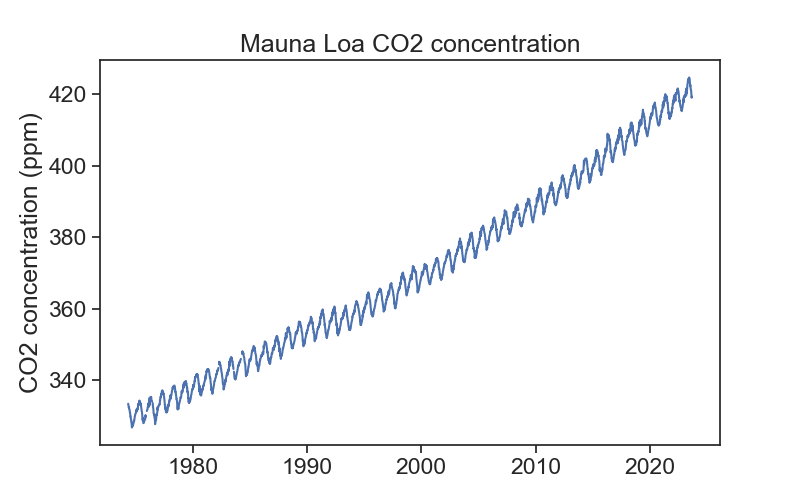

In [65]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(df['co2'])
ax.set(ylabel="CO2 concentration (ppm)",
       title="Mauna Loa CO2 concentration");

## trend

In [66]:
df['trend365D'] = df['co2'].rolling('365D', center=True).mean()
df['co2_detrended'] = df['co2'] - df['trend365D']

In [67]:
df

,co2,decimal_date,trend365D,co2_detrended
date,,,,
1974-05-19,333.37,1974.378082,329.511111,3.858889
1974-05-26,332.95,1974.397260,329.473571,3.476429
1974-06-02,332.35,1974.416438,329.450345,2.899655
1974-06-09,332.20,1974.435616,329.448333,2.751667
1974-06-16,332.37,1974.454795,329.459032,2.910968
...,...,...,...,...
2023-07-23,421.28,2023.556050,421.939032,-0.659032
2023-07-30,420.83,2023.575228,422.012667,-1.182667
2023-08-06,420.02,2023.594406,422.088621,-2.068621


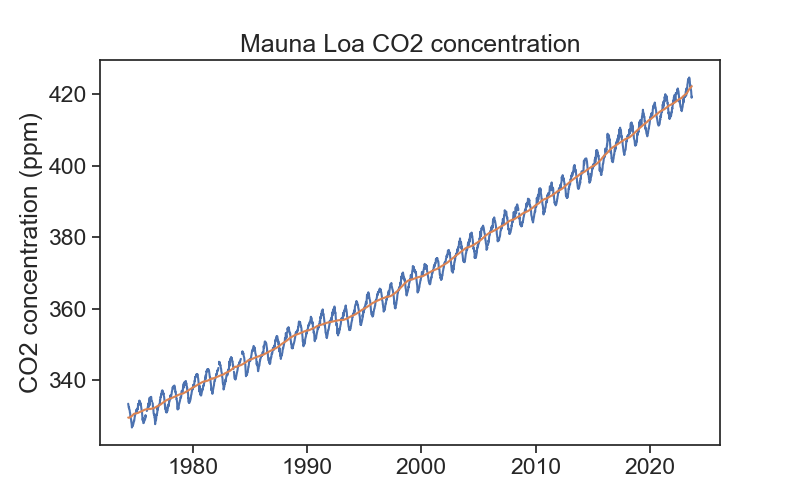

In [68]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(df['co2'])
ax.plot(df['trend365D'])
ax.set(ylabel="CO2 concentration (ppm)",
       title="Mauna Loa CO2 concentration");

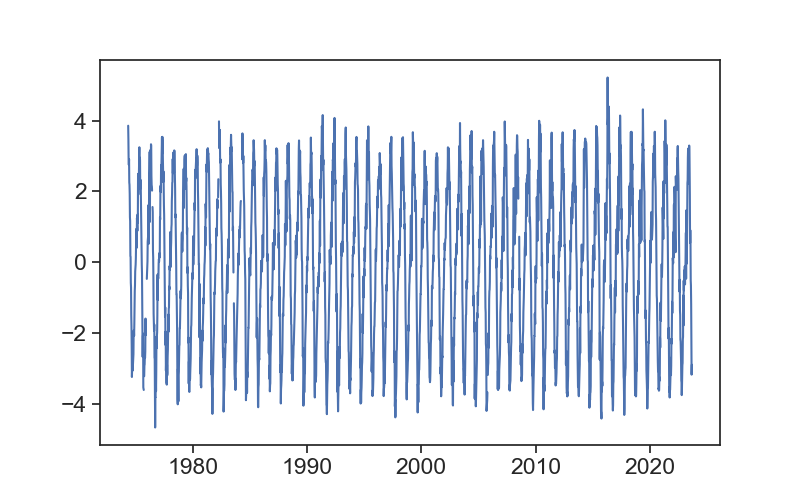

In [69]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(df['co2_detrended'])

In [95]:
gb_year = df.groupby(df.index.year)

/var/folders/c3/7hp0d36n6vv8jc9hm2440__00000gn/T/ipykernel_57919/1560271468.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, figsize=(8,4))


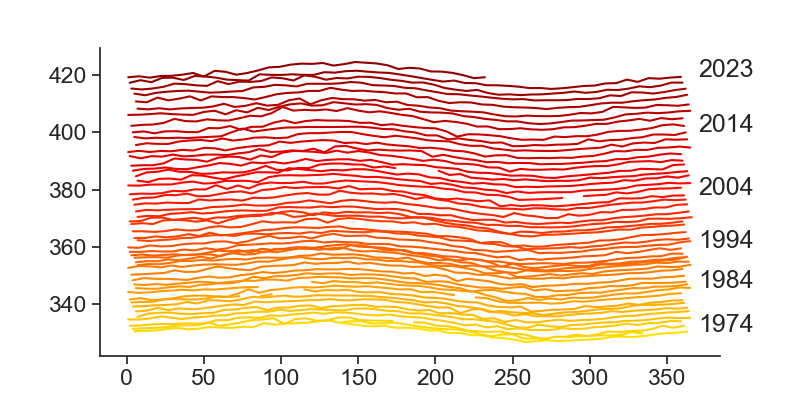

In [96]:
# %matplotlib widget

fig, ax = plt.subplots(1, figsize=(8,4))

colors = plt.cm.hot_r(np.linspace(0.3, 0.8, len(gb_year)))

# Plot 'co2' for each year
for i, (year, data) in enumerate(gb_year):
    ax.plot(data.index.day_of_year, data['co2'].values, color=colors[i])

for y in [1974, 1984, 1994, 2004, 2014, 2023]:
    this_year = gb_year.get_group(y)
    ax.text(370, this_year['co2'][-1], f"{y}")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


In [97]:
df

,co2,decimal_date,trend365D,co2_detrended
date,,,,
1974-05-19,333.37,1974.378082,329.511111,3.858889
1974-05-26,332.95,1974.397260,329.473571,3.476429
1974-06-02,332.35,1974.416438,329.450345,2.899655
1974-06-09,332.20,1974.435616,329.448333,2.751667
1974-06-16,332.37,1974.454795,329.459032,2.910968
...,...,...,...,...
2023-07-23,421.28,2023.556050,421.939032,-0.659032
2023-07-30,420.83,2023.575228,422.012667,-1.182667
2023-08-06,420.02,2023.594406,422.088621,-2.068621


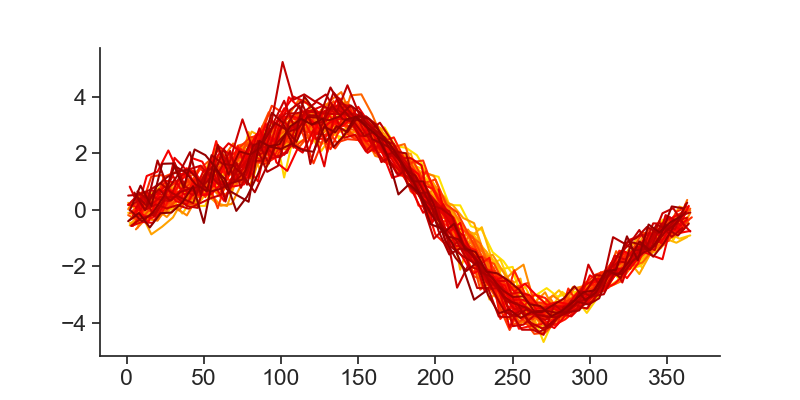

In [100]:
# %matplotlib widget

fig, ax = plt.subplots(1, figsize=(8,4))

colors = plt.cm.hot_r(np.linspace(0.3, 0.8, len(gb_year)))

for i, (year, data) in enumerate(gb_year):
    ax.plot(data.index.day_of_year, data['co2_detrended'], color=colors[i])

gb_year['co2_detrended'].mean()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


In [99]:
gb_year['co2_detrended'].mean()

date
1974   -0.476982
1975    0.064737
1976   -0.116782
1977    0.029913
1978   -0.013859
1979   -0.005189
1980    0.011223
1981    0.026028
1982   -0.023990
1983    0.078191
1984   -0.080780
1985    0.046252
1986   -0.029126
1987   -0.064448
1988    0.055911
1989   -0.011047
1990   -0.002645
1991   -0.006328
1992    0.012398
1993   -0.049829
1994    0.009176
1995   -0.007031
1996    0.066807
1997   -0.103806
1998    0.075729
1999    0.017072
2000   -0.008864
2001   -0.032983
2002   -0.011691
2003    0.011651
2004   -0.044648
2005    0.036898
2006   -0.024881
2007    0.053930
2008   -0.014578
2009   -0.073423
2010    0.082605
2011   -0.021455
2012   -0.057198
2013    0.048984
2014    0.010033
2015   -0.106415
2016    0.072221
2017    0.047932
2018   -0.091430
2019    0.018229
2020    0.028360
2021    0.015207
2022    0.048922
2023    0.811328
Name: co2_detrended, dtype: float64

In [ ]:
gb_year['co2_detrended'].mean()

date
1974   -0.476982
1975    0.064737
1976   -0.116782
1977    0.029913
1978   -0.013859
1979   -0.005189
1980    0.011223
1981    0.026028
1982   -0.023990
1983    0.078191
1984   -0.080780
1985    0.046252
1986   -0.029126
1987   -0.064448
1988    0.055911
1989   -0.011047
1990   -0.002645
1991   -0.006328
1992    0.012398
1993   -0.049829
1994    0.009176
1995   -0.007031
1996    0.066807
1997   -0.103806
1998    0.075729
1999    0.017072
2000   -0.008864
2001   -0.032983
2002   -0.011691
2003    0.011651
2004   -0.044648
2005    0.036898
2006   -0.024881
2007    0.053930
2008   -0.014578
2009   -0.073423
2010    0.082605
2011   -0.021455
2012   -0.057198
2013    0.048984
2014    0.010033
2015   -0.106415
2016    0.072221
2017    0.047932
2018   -0.091430
2019    0.018229
2020    0.028360
2021    0.015207
2022    0.048922
2023    0.811328
Name: co2_detrended, dtype: float64

In [90]:
ty[-1]

330.38

fill missing data. interpolate method: 'time'  
[interpolation methods visualized](https://thepythonyouneed.com/how-to-interpolate-values-with-pandas/)

In [9]:
df['co2'] = (df['average'].resample("D") #resample daily
                          .interpolate(method='time') #interpolate by time
            )
df

,year,month,day,decimal,average,ndays,1 year ago,10 years ago,increase since 1800,co2
date,,,,,,,,,,
1974-05-19,1974,5,19,1974.3795,333.37,5,NaN,NaN,50.40,333.37
1974-05-26,1974,5,26,1974.3986,332.95,6,NaN,NaN,50.06,332.95
1974-06-02,1974,6,2,1974.4178,332.35,5,NaN,NaN,49.60,332.35
1974-06-09,1974,6,9,1974.4370,332.20,7,NaN,NaN,49.65,332.20
1974-06-16,1974,6,16,1974.4562,332.37,7,NaN,NaN,50.06,332.37
...,...,...,...,...,...,...,...,...,...,...
2022-06-26,2022,6,26,2022.4836,420.31,7,418.14,395.36,138.71,420.31
2022-07-03,2022,7,3,2022.5027,419.73,6,417.49,395.15,138.64,419.73
2022-07-10,2022,7,10,2022.5219,419.08,6,417.25,394.59,138.52,419.08


## decompose data
`seasonal_decompose` returns an object with four components:

* observed: $Y(t)$
* trend: $T(t)$
* seasonal: $S(t)$
* resid: $e(t)$

Additive model:
$$
Y(t) = T(t) + S(t) + e(t)
$$

Multiplicative model:
$$
Y(t) = T(t) \times S(t) \times e(t)
$$

#### Interlude
learn how to use `zip` in a loop

In [10]:
letters = ['a', 'b', 'c', 'd', 'e']
numbers = [1, 2, 3, 4, 5]
# zip let's us iterate over to lists at the same time
for l, n in zip(letters, numbers):
    print(f"{l} = {n}")

a = 1
b = 2
c = 3
d = 4
e = 5


Plot each component separately.

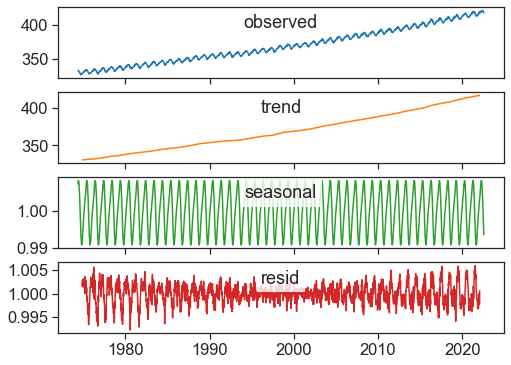

In [11]:
# %matplotlib widget

fig, ax = plt.subplots(4, 1, figsize=(8,6), sharex=True)
decomposed_m = seasonal_decompose(df['co2'], model='multiplicative')
decomposed_a = seasonal_decompose(df['co2'], model='additive')
decomposed = decomposed_m
pos = (0.5, 0.9)
components =["observed", "trend", "seasonal", "resid"]
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]
for axx, component, color in zip(ax, components, colors):
    data = getattr(decomposed, component)
    axx.plot(data, color=color)
    axx.text(*pos, component, bbox=dict(facecolor='white', alpha=0.8),
           transform=axx.transAxes, ha='center', va='top')

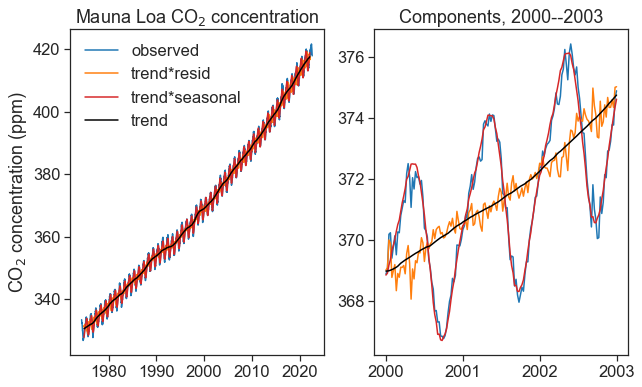

In [34]:
# %matplotlib widget

decomposed = decomposed_m

fig, ax = plt.subplots(1, 2, figsize=(10,6))
ax[0].plot(df['co2'], color="tab:blue", label="observed")
ax[0].plot(decomposed.trend * decomposed.resid, color="tab:orange", label="trend*resid")
ax[0].plot(decomposed.trend * decomposed.seasonal, color="tab:red", label="trend*seasonal")
ax[0].plot(decomposed.trend, color="black", label="trend")
ax[0].set(ylabel="CO$_2$ concentration (ppm)",
          title="Mauna Loa CO$_2$ concentration")
ax[0].legend(frameon=False)

start = "2000-01-01"
end = "2003-01-01"
zoom = slice(start, end)
ax[1].plot(df.loc[zoom, 'co2'], color="tab:blue", label="observed")
ax[1].plot((decomposed.trend * decomposed.resid)[zoom], color="tab:orange", label="trend*resid")
ax[1].plot((decomposed.trend * decomposed.seasonal)[zoom], color="tab:red", label="trend*seasonal")
ax[1].plot(decomposed.trend[zoom], color="black", label="trend")
date_form = DateFormatter("%Y")
ax[1].xaxis.set_major_formatter(date_form)
ax[1].xaxis.set_major_locator(mdates.YearLocator(1))
ax[1].set_title("Components, 2000--2003");
